In [53]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import BCELoss
from torch.autograd import Variable
from torch.nn.init import  kaiming_normal
import torch.utils.data as data_utils
from collections import OrderedDict

from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [54]:
def load_xy_data():
    print('loading data ...')
    df = pd.read_csv('./train.csv', low_memory=False)
    print('complete ...')

    print('formatting ...')
    drop_cols = [col for col in df.columns if 'OTHERS' in col] + [col for col in df.columns if 'REC' in col] + ['LN2_RIndLngBEOth', 'LN2_WIndLngBEOth', 'train_id']
    df.drop(columns=drop_cols, inplace=True)
    columns = [col for col in df.columns if col != 'is_female']
    y = df['is_female'].values
    X = df[columns].copy()


    print('imputing missing values ...')
    X.fillna(-1, inplace=True)
    print(X.shape, y.shape)
    return X, y

def get_mappers(inputX):
    """
    X_mapped, mappers, categorical_stats, emb_szs = get_mappers(X)
    """
    X = inputX.copy()
    mappers = {}
    columns = X.columns
    
    print('converting to category ...')
    for idx, col in enumerate(columns):
        if idx % 100 == 0:
            print(idx)
        X[col] = X[col].astype('category')
        mappers[col] = {labels: idx for idx, labels in enumerate(X[col].cat.categories)}

    print('calculating cardinality')
    categorical_stats = OrderedDict()
    for col in X.columns:
        categorical_stats[col] = len(X[col].cat.categories)+1

    embedding_sizes = OrderedDict()
    for ky, vl in categorical_stats.items():
        embedding_sizes[ky] = (vl, min(50, (vl+1)//2))
        
    print('remapping columns to int')        
    for col in columns:
        X[col] = X[col].map(mappers[col])
        
    emb_szs = list(embedding_sizes.values())
    input_feats_ct = len(embedding_sizes.keys())
    print('complete')
    
    return X, mappers, categorical_stats, emb_szs

In [55]:
def norm_init_emb(embedding):
    """ 
    Limit the initialization to 1/dim 
    Doesn't return anything
    """
    vec_dim = embedding.weight.data.size(1)
    sc = 2/(vec_dim + 1)
    embedding.weight.data.uniform_(-sc,sc)
    
    
class EmbeddingModel(nn.Module):
    def __init__(self, emb_szs, layer_sizes, output_dim, drop_pct, emb_drop_pct):
        super(EmbeddingModel, self).__init__()
        
        # Number of layers
        self.output_dim = output_dim
        self.n_layers = len(layer_sizes)
        print('number of feats:% d' % len(emb_szs))
        
        # initialize the embeddings
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])        
        self.total_emb_var_ct = 0        
        for emb in self.embs:
            norm_init_emb(emb)
            self.total_emb_var_ct += emb.embedding_dim
        
        self.emb_drop = nn.Dropout(emb_drop_pct)
        print('total embedding parameters %d' % self.total_emb_var_ct)
        
        
        # initialize the layers, will make as many 
        # sub blocks as passed in by layer_size list 
        # ex. [n1, n2, n3] => 3 lin layer network + 1 output layer
        self.seq_model = torch.nn.Sequential()
        
        layer_sizes = [self.total_emb_var_ct] + layer_sizes
        for i in range(self.n_layers):
            linlayer = nn.Linear(layer_sizes[i],layer_sizes[i+1])
            kaiming_normal(linlayer.weight.data)            
            self.seq_model.add_module("lin_%d" % i, linlayer )
            self.seq_model.add_module("relu_%d" % i, nn.ReLU())
            self.seq_model.add_module("batch_norm_%d" % i, nn.BatchNorm1d(layer_sizes[i+1]))
            self.seq_model.add_module("drop_out_%d" % i, nn.Dropout(drop_pct))
            
        out_lin = nn.Linear(layer_sizes[-1], output_dim)
        kaiming_normal(out_lin.weight.data)            
        self.seq_model.add_module("output", out_lin)
        
        # initialize the weights of linear layers
        for ly in self.seq_model:
            if type(ly) == nn.Linear:
                kaiming_normal(ly.weight.data)

    def forward(self, x):
        # lookup embeddings
        lkups = [emb(x[:,idx]) for idx, emb in enumerate(self.embs)]
        glued = torch.cat(lkups,1)
        x = self.emb_drop(glued)
        x = self.seq_model(x)
        if self.output_dim == 1:
            x = F.sigmoid(x)
        else:
            x = F.log_softmax(x, output_dim)
        return x

### Load the data

In [78]:
X, y = load_xy_data()
X_mapped, mappers, categorical_stats, emb_szs = get_mappers(X)

loading data ...
complete ...
formatting ...
imputing missing values ...
(18255, 1122) (18255,)
converting to category ...
0
100
200
300
400
500
600
700
800
900
1000
1100
calculating cardinality
remapping columns to int
complete


In [67]:
X_tensor = torch.from_numpy(X_mapped.head(18200).as_matrix())
y_tensor = torch.from_numpy(y[:18200]).view(-1,1)

bz = 50
train = data_utils.TensorDataset(X_tensor, y_tensor)
train_loader = data_utils.DataLoader(train, batch_size=bz, shuffle=True)

### Train 3 Layer NN

In [68]:
layer_sizes = [1000, 300, 100]

# initialize 
model = EmbeddingModel(emb_szs=emb_szs, layer_sizes=layer_sizes, output_dim=1, drop_pct=0.3, emb_drop_pct=0.3)
model.seq_model

n_epochs = 4
wd=1e-5
avg_loss = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
loss_fn = torch.nn.BCELoss(size_average=False)


for learning_rate in [0.01, 0.003, 0.001, 0.0003, 0.0001]:
    print('learning rate %f' % learning_rate)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
        
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0
        
        train_dl = iter(train_loader)
        running_loss = 0.0
        for i, batch in enumerate(train_dl):
            data, labels = batch
            bz = data.size()[0]

            data_var = Variable(data)
            label_var = Variable(labels.float(), requires_grad=False)

            y_pred = model(data_var)
            y_pred_hard = y_pred > 0.5
            correct = (label_var.view(-1,1).eq(y_pred_hard.float())).sum()
            running_correct += correct.float().data    

            loss = loss_fn(y_pred, label_var)
            running_loss += loss.data[0]

            if i % 25 == 24:
                avg_loss.append(running_loss/25)
                acc = running_correct/50/25.
                print('[%d/%d] - %d/%d loss: %f, acc: %f' %(epoch+1, n_epochs, i*bz, 18200, running_loss/25, acc))
                
                running_loss = 0
                running_correct = 0

            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()


        
        

number of feats: 10
total embedding parameters 182
learning rate 0.010000
[1/4] - 1200/18200 loss: 21.189893, acc: 0.810400
[1/4] - 2450/18200 loss: 18.539863, acc: 0.828000
[1/4] - 3700/18200 loss: 17.831759, acc: 0.850400
[1/4] - 4950/18200 loss: 15.972036, acc: 0.874400
[1/4] - 6200/18200 loss: 15.808735, acc: 0.867200
[1/4] - 7450/18200 loss: 16.199249, acc: 0.856000
[1/4] - 8700/18200 loss: 15.310520, acc: 0.864800
[1/4] - 9950/18200 loss: 16.191557, acc: 0.855200
[1/4] - 11200/18200 loss: 15.789908, acc: 0.865600
[1/4] - 12450/18200 loss: 16.235570, acc: 0.864800
[1/4] - 13700/18200 loss: 16.104269, acc: 0.867200
[1/4] - 14950/18200 loss: 15.081647, acc: 0.872800
[1/4] - 16200/18200 loss: 15.610961, acc: 0.880000
[1/4] - 17450/18200 loss: 13.738026, acc: 0.890400
[2/4] - 1200/18200 loss: 14.117018, acc: 0.885600
[2/4] - 2450/18200 loss: 13.789540, acc: 0.880800
[2/4] - 3700/18200 loss: 15.519359, acc: 0.870400
[2/4] - 4950/18200 loss: 13.425933, acc: 0.893600
[2/4] - 6200/18200 l

[4/4] - 11200/18200 loss: 8.900819, acc: 0.929600
[4/4] - 12450/18200 loss: 9.102890, acc: 0.926400
[4/4] - 13700/18200 loss: 8.080157, acc: 0.929600
[4/4] - 14950/18200 loss: 9.017907, acc: 0.928800
[4/4] - 16200/18200 loss: 7.161745, acc: 0.932000
[4/4] - 17450/18200 loss: 7.846181, acc: 0.932000
learning rate 0.000300
[1/4] - 1200/18200 loss: 8.839418, acc: 0.922400
[1/4] - 2450/18200 loss: 8.610362, acc: 0.929600
[1/4] - 3700/18200 loss: 9.829206, acc: 0.911200
[1/4] - 4950/18200 loss: 6.982679, acc: 0.948000
[1/4] - 6200/18200 loss: 8.290683, acc: 0.922400
[1/4] - 7450/18200 loss: 6.870121, acc: 0.945600
[1/4] - 8700/18200 loss: 7.850580, acc: 0.936000
[1/4] - 9950/18200 loss: 7.348506, acc: 0.936800
[1/4] - 11200/18200 loss: 8.296039, acc: 0.932800
[1/4] - 12450/18200 loss: 8.304887, acc: 0.923200
[1/4] - 13700/18200 loss: 7.403085, acc: 0.931200
[1/4] - 14950/18200 loss: 7.469584, acc: 0.935200
[1/4] - 16200/18200 loss: 7.557291, acc: 0.940000
[1/4] - 17450/18200 loss: 6.575661,

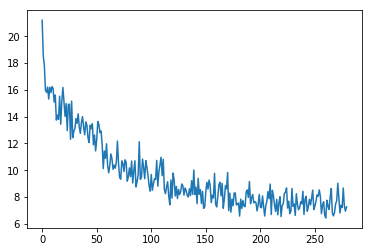

In [69]:
plt.plot(avg_loss)

In [70]:
# for emb in model.embs:
#     print(emb.weight)

### Change X into Embeddings

In [71]:
keys = mappers.keys()
emb_mtx = {}
for field, emb in zip(keys, model.embs):
    emb_mtx[field] = emb.weight.data.numpy() 

In [72]:
def get_train():
    print('loading data ...')
    df = pd.read_csv('./train.csv', low_memory=False)
    test = pd.read_csv('./test.csv', low_memory=False)
    print('complete ...')

    print('formatting ...')
    drop_cols = [col for col in df.columns if 'OTHERS' in col] + [col for col in df.columns if 'REC' in col] + ['LN2_RIndLngBEOth', 'LN2_WIndLngBEOth', 'train_id']
    drop_cols_test = [col for col in df.columns if 'OTHERS' in col] + [col for col in df.columns if 'REC' in col] + ['LN2_RIndLngBEOth', 'LN2_WIndLngBEOth', 'test_id']
    
    df.drop(columns=drop_cols, inplace=True)
    test.drop(columns=drop_cols_test, inplace=True)
    
    columns = [col for col in df.columns if col != 'is_female']
    y = df['is_female'].values
    X = df[columns].copy()
    X_test = test[columns].copy()

    
    print('imputing missing values ...')
    X.fillna(-1, inplace=True)
    X_test.fillna(-1, inplace=True)
    
    mappers = {}
    print('complete')
    return X, y, X_test


def get_emb_df(X, emb_mtx):
    mini_dfs = []
    
    print('applying embeddings')
    for col in X.columns.values:
        idxs = X[col].map(mappers[col])
        
        # fill nones with global mean
        idxs[idxs.isna()] = max(idxs)+1
        idxs = np.array(idxs, dtype = int)
        
        # get embedding matrix
        mtx = emb_mtx[col]
        
        # calculate global mean for missing values
        glb_mean = np.mean(mtx,axis=0)        
        
        # add global mean to bottom of matrix
        mtx = np.concatenate([mtx, glb_mean.reshape(1,-1)], axis=0)
        
        # create dataframe
        jf = pd.DataFrame(mtx[idxs, :])
        jf.columns = [col+'_%d' %i for i in jf.columns]
        
        # append
        mini_dfs.append(jf)
    print('combining dfs')
    out_df = pd.concat(mini_dfs, axis=1)
    
    return out_df

X, y, X_test = get_train()
X_emb = get_emb_df(X[top_f], emb_mtx)
X_emb_test = get_emb_df(X_test[top_f], emb_mtx)

loading data ...
complete ...
formatting ...
imputing missing values ...
complete
applying embeddings
combining dfs
applying embeddings
combining dfs


In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_emb, y, test_size=0.3)
m = xgb.XGBClassifier(max_depth = 6, 
                      learning_rate=0.1,
                      reg_alpha=0.1, 
                      colsample_bytree = 0.5,
                      colsample_bylevel = 0.5,
                      reg_lambda=0.01, 
                      n_estimators=500,
                      n_jobs = -1
                     )

m.fit(X_train, 
      y_train, 
      eval_set=([X_train,y_train],[X_val, y_val]),
      eval_metric='auc',
      early_stopping_rounds=50)


[0]	validation_0-auc:0.962216	validation_1-auc:0.956286
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.96792	validation_1-auc:0.962703
[2]	validation_0-auc:0.971664	validation_1-auc:0.967035
[3]	validation_0-auc:0.973383	validation_1-auc:0.968572
[4]	validation_0-auc:0.974232	validation_1-auc:0.969471
[5]	validation_0-auc:0.975184	validation_1-auc:0.969679
[6]	validation_0-auc:0.976124	validation_1-auc:0.970757
[7]	validation_0-auc:0.97666	validation_1-auc:0.971304
[8]	validation_0-auc:0.9778	validation_1-auc:0.972294
[9]	validation_0-auc:0.978755	validation_1-auc:0.972827
[10]	validation_0-auc:0.979448	validation_1-auc:0.973299
[11]	validation_0-auc:0.980177	validation_1-auc:0.973561
[12]	validation_0-auc:0.980733	validation_1-auc:0.973708
[13]	validation_0-auc:0.981321	validation_1-auc:0.973646
[14]	validation_0-auc:0.981983	validation_1-auc:0.973894
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [74]:
pred_hard = m.predict(X_emb)

In [75]:
np.sum(np.equal(y, pred_hard))/len(y)

0.96713229252259658

In [76]:
pred_proba = m.predict_proba(X_emb_test)
pred_df = pd.DataFrame(pred_proba)

In [77]:
df_sub = pd.read_csv('./sample_submission.csv')
df_sub['is_female'] = pred_df.iloc[:,1]
df_sub.to_csv('nn_embedding_9.csv', index=False)

In [292]:
df_sub

,test_id,is_female
0,0,0.999973
1,1,0.001265
2,2,0.577027
3,3,0.999694
4,4,0.960567
5,5,0.999954
6,6,0.003924
7,7,0.999921
8,8,0.002181
9,9,0.054982
